In [1]:
import pymaid
import logging
import pandas as pd
import numpy as np
from itertools import chain, combinations
from upsetplot import plot
from matplotlib import pyplot as plt

In [7]:
rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

path = "/Users/kareefullah/Desktop/neurodata/neurodata/platy-data"

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


In [2]:
# side: ["left", "right", "center"]
# class: ["Sensory neuron", "interneuron", "motorneuron"]
# segment: ["segment_0", "segment_1", "segment_2", "segment_3", "head", "pygidium"]
# type: ["celltype1", "celltype2", ... "celltype180"]
# group: ["cellgroup1", "cellgroup2", ... "cellgroup18"]
# category can be "side" or "class" or "segment" or "type" or "group"

def get_labels_from_annotation(annot_list, category="side"):
    all_ids = pymaid.get_skids_by_annotation(annot_list)
    id_annot = []

    if category == "type" or category == "group":
        for annot in annot_list:
            ids = pymaid.get_skids_by_annotation(annot)
            for id in ids:
                if id in all_ids:
                    #ensure every id gets only one label
                    all_ids.remove(id)
                    if category == "type":
                        label = annot.split("celltype")[1]
                    else:
                        label = annot.split("cellgroup")[1]
                    id_annot.append([id, label])

    # power set of annot_list reversed: first look at the intersections within annot_list then singular entries
    elif category == "side" or category == "class" or category == "segment":
        annot_power = list(
            chain.from_iterable(
                combinations(annot_list, r) for r in range(len(annot_list) + 1)
            )
        )
        annot_power.reverse()

        for annots in annot_power:

            # skip the empty set in the power set
            if len(annots) != 0:
                ids = pymaid.get_skids_by_annotation(annots, intersect=True)

                # assign one label to every id
                for id in ids:
                    if id in all_ids:
                        # make sure cannot find id again if it is already added to id_list
                        all_ids.remove(id)
                        label = ""
                        for annot in annots:
                            if category == "side":
                                label += annot[0]
                            elif category == "class":
                                label += annot[0].lower()
                            elif category == "segment":
                                if annot[0] == "s":
                                    label += annot[-1]
                                else:
                                    label += annot
                        id_annot.append([id, label])

    else:
        raise ValueError("category is invalid")

    id_annot = np.array(id_annot)

    #ids are first column, annots are second column
    ids = id_annot[:, 0]
    annots = id_annot[:, 1]
    return pd.Series(index=ids, data=annots, name=category)

In [4]:
#returns boolean pandas series: False if element is "N/A", else True
def has_category(annotations, category="side"):
    has_list = []
    series_name = "has_{}".format(category)
    for val in annotations[category]:
        if val != "N/A":
            has_list.append(True)
        else:
            has_list.append(False)
    return pd.Series(index=annotations.index, data=has_list, name=series_name)

In [5]:
#returns boolean pandas series: True if element=name, else False
def has_element(annotations, category="side", name="l"):
    has_element = []
    series_name = "{}_{}".format(category, name)
    for val in annotations[category]:
        if val == name:
            has_element.append(True)
        else:
            has_element.append(False)
    return pd.Series(index=annotations.index, data=has_element, name=series_name)

In [3]:
#list of annotations for the different categories
side_list = ["left", "right", "center"]
class_list = ["Sensory neuron", "interneuron", "motorneuron"]
segment_list = [
    "segment_0",
    "segment_1",
    "segment_2",
    "segment_3",
    "head",
    "pygidium",
]
type_list = []
for i in range(1, 181):
    type_list.append("celltype{}".format(i))

group_list = []
for j in range(1, 18):
    group_list.append("cellgroup{}".format(j))

In [8]:
#generating the pandas series of labels of the different categories
side_labels = get_labels_from_annotation(side_list, category="side")
class_labels = get_labels_from_annotation(class_list, category="class")
segment_labels = get_labels_from_annotation(segment_list, category="segment")
type_labels = get_labels_from_annotation(type_list, category="type")
group_labels = get_labels_from_annotation(group_list, category="group")

Fetching:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching:   0%|          | 0/6 [00:00<?, ?it/s]

Fetching:   0%|          | 0/180 [00:00<?, ?it/s]

Fetching:   0%|          | 0/17 [00:00<?, ?it/s]

In [11]:
#make dataframe by concatenating all the series
series_ids = [side_labels, class_labels, segment_labels, type_labels, group_labels]
annotations = pd.concat(series_ids, axis=1, ignore_index=False, names="ID").fillna(
    "N/A"
)

In [12]:
#generate boolean pandas series for the different categories
has_side = has_category(annotations, category="side")
has_class = has_category(annotations, category="class")
has_segment = has_category(annotations, category="segment")
has_type = has_category(annotations, category="type")
has_group = has_category(annotations, category="group")

In [14]:
bool_ids = [has_side, has_class, has_segment, has_type, has_group]

#boolean dataframe from concatenating the boolean series
annotations_bool = pd.concat(bool_ids, axis=1, ignore_index=False, names="ID").fillna(
    "N/A"
)

#group the annotations dataframe by the categories and get the number of cells for each subset of categories
bool_counts = annotations_bool.groupby(bool_ids).size()

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

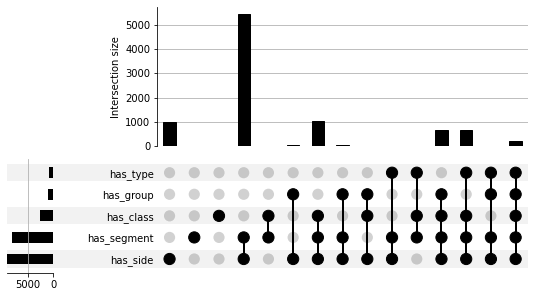

In [15]:
#generate the upsetplot of the grouped dataframe
plot(bool_counts)

In [16]:
#generate boolean pandas series for the different names within their respective category
has_left = has_element(annotations, category="side", name="l")
has_right = has_element(annotations, category="side", name="r")
has_center = has_element(annotations, category="side", name="c")

has_sensory = has_element(annotations, category="class", name="s")
has_inter = has_element(annotations, category="class", name="i")
has_motor = has_element(annotations, category="class", name="m")

has_seg0 = has_element(annotations, category="segment", name="0")
has_seg1 = has_element(annotations, category="segment", name="1")
has_seg2 = has_element(annotations, category="segment", name="2")
has_seg3 = has_element(annotations, category="segment", name="3")
has_head = has_element(annotations, category="segment", name="head")
has_pyg = has_element(annotations, category="segment", name="pygidium")

In [19]:
bool_ids = [
    has_left,
    has_right,
    has_center,
    has_sensory,
    has_inter,
    has_motor,
    has_seg0,
    has_seg1,
    has_seg2,
    has_seg3,
    has_head,
    has_pyg,
]

#boolean dataframe from concatenating the boolean series
annotations_bool = pd.concat(bool_ids, axis=1, ignore_index=False, names="ID").fillna(
    "N/A"
)

#group the annotations dataframe by the names and get the number of cells for each subset of names
bool_counts = annotations_bool.groupby(bool_ids).size()

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

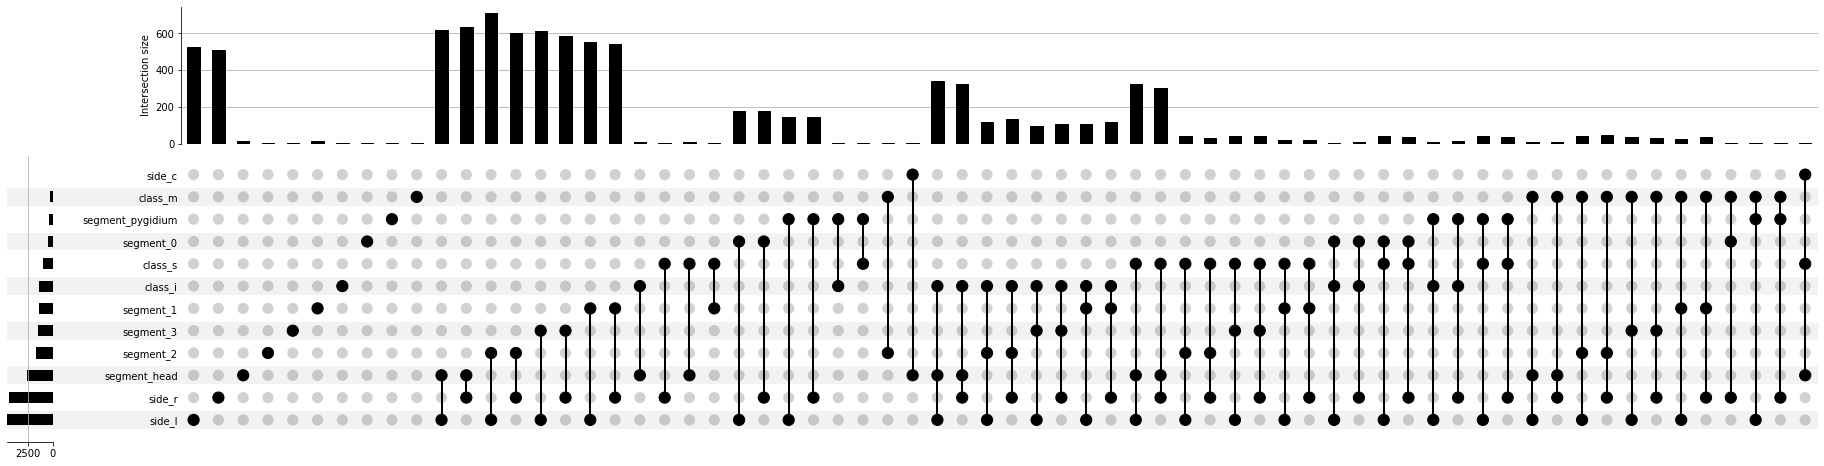

In [20]:
#generate the upsetplot of the grouped dataframe
plot(bool_counts)